Sentiment Analysis - Mekhi Green

In [6]:
# Setup & Imports
import os, re, sys, json, math, random, pickle
import numpy as np, pandas as pd
import nltk; nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [8]:
# Config & Robust Path Detection
import glob
CANDIDATES = [
    "/content/customer_reviewers.tsv",
    "./customer_reviewers.tsv",
] + glob.glob("/content/**/*.tsv", recursive=True) + glob.glob("**/*.tsv", recursive=True)

DATA_PATH = None
for p in CANDIDATES:
    if os.path.exists(p) and os.path.basename(p) == "customer_reviewers.tsv":
        DATA_PATH = os.path.abspath(p); break
if not DATA_PATH:
    raise FileNotFoundError("Upload 'customer_reviewers.tsv' to Colab (Files panel) and re-run.")

ARTIFACT_DIR = "/content/artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)
NUM_WORDS, EMBED_DIM, MAXLEN, LSTM_UNITS = 500, 120, 100, 176
TEST_SIZE, EPOCHS, BATCH_SIZE, VERBOSE = 0.20, 5, 32, "auto"
print("Using DATA_PATH:", DATA_PATH)

Using DATA_PATH: /content/customer_reviewers.tsv


In [9]:
# Load & Preview (10 rows)
df = pd.read_csv(DATA_PATH, sep="\t", encoding="utf-8", engine="python")
print("Shape:", df.shape)
display(df.head(10))

Shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [10]:
# Validate & Handle Missing Values

# 1. Show which columns have missing values and how many
missing_cols = df.columns[df.isnull().any()].tolist()
print("Columns with missing BEFORE handling:", missing_cols)
if missing_cols:
    print("Missing counts per column:")
    print(df[missing_cols].isnull().sum())

# 2. Strategy:
#    - For text (object) columns: fill NaN with empty string ""
#    - For non-text columns: drop rows with NaN in those columns
text_like = []
non_text_like = []
for col in missing_cols:
    if df[col].dtype == "object":
        text_like.append(col)
    else:
        non_text_like.append(col)

if text_like:
    df[text_like] = df[text_like].fillna("")

if non_text_like:
    df = df.dropna(subset=non_text_like)

# 3. Verify Again
print("\nAFTER handling missing values:")
print("Any missing left?:", df.isnull().any().any())
print("Columns with missing AFTER handling:", df.columns[df.isnull().any()].tolist())

# 4. Explicitly set the correct text & label columns for this dataset
#    (Amazon Alexa reviews: verified_reviews = text, feedback = binary label)
if "verified_reviews" not in df.columns or "feedback" not in df.columns:
    raise ValueError("Expected columns 'verified_reviews' and 'feedback' not found in the dataset.")

text_col = "verified_reviews"
label_col = "feedback"

print(f"\nUsing text_col = '{text_col}', label_col = '{label_col}'")
print("Unique labels in feedback:", sorted(df[label_col].unique()))

Columns with missing BEFORE handling: ['verified_reviews']
Missing counts per column:
verified_reviews    1
dtype: int64

AFTER handling missing values:
Any missing left?: False
Columns with missing AFTER handling: []

Using text_col = 'verified_reviews', label_col = 'feedback'
Unique labels in feedback: [np.int64(0), np.int64(1)]


In [11]:
# Cleaning with Stopwords

STOPWORDS = set(stopwords.words("english"))

# Keep these negation words; they are crucial for sentiment
NEGATION_WORDS = {"not", "no", "nor", "never", "none", "nobody", "nothing", "neither"}
STOPWORDS = STOPWORDS - NEGATION_WORDS

_url_pat = re.compile(r"http\\S+|www\\.\\S+")
_tag_pat = re.compile(r"<.*?>")
_mention_pat = re.compile(r"@[A-Za-z0-9_]+")
_nonalpha_pat = re.compile(r"[^a-zA-Z\\s]+")

def normalize_text(s: str) -> str:
    s = s.lower()
    s = _url_pat.sub(" ", s)
    s = _tag_pat.sub(" ", s)
    s = _mention_pat.sub(" ", s)
    s = _nonalpha_pat.sub(" ", s)
    s = re.sub(r"\\s+", " ", s).strip()
    return s

def clean_text_dataframe(in_df: pd.DataFrame, col: str) -> pd.DataFrame:
    out = in_df.copy()
    toks = []
    for x in out[col].astype(str).tolist():
        norm = normalize_text(x)
        toks.append(" ".join([t for t in norm.split() if t not in STOPWORDS]))
    out["clean_text"] = toks
    return out

df_clean = clean_text_dataframe(df, text_col)
display(df_clean[[text_col, "clean_text", label_col]].head(10))

,verified_reviews,clean_text,feedback
0,Love my Echo!,love echo,1
1,Loved it!,loved,1
2,"Sometimes while playing a game, you can answer...",sometimes playing game answer question correct...,1
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learns dinosaurs control ...,1
4,Music,music,1
5,I received the echo as a gift. I needed anothe...,received echo gift needed another bluetooth so...,1
6,"Without having a cellphone, I cannot use many ...",without cellphone cannot use many features ipa...,1
7,I think this is the 5th one I've purchased. I'...,think th one purchased working getting one eve...,1
8,looks great,looks great,1
9,Love it! I’ve listened to songs I haven’t hear...,love listened songs heard since childhood get ...,1


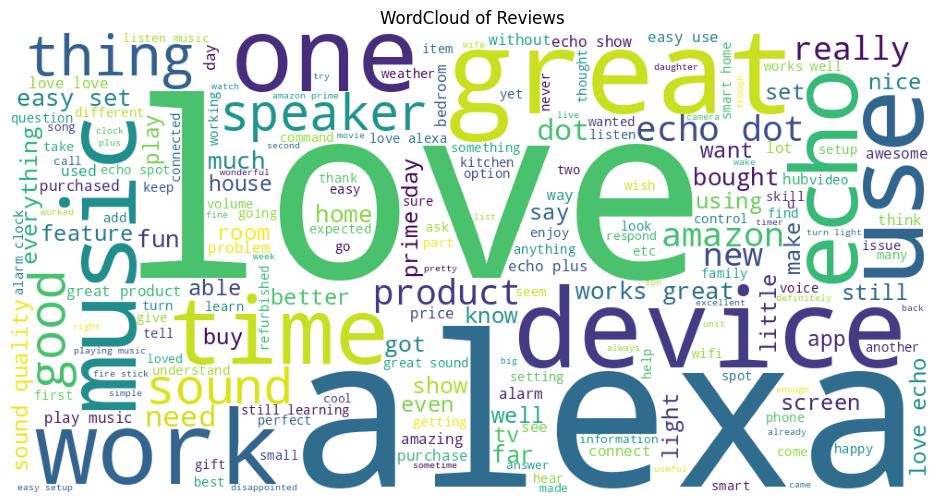

In [12]:
# WordCloud
all_text = " ".join(df_clean["clean_text"].astype(str).tolist())
wc = WordCloud(width=1000, height=500, background_color="white").generate(all_text)
plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis("off"); plt.title("WordCloud of Reviews"); plt.show()

In [13]:
# Label Encoding & One-Hot
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y_int = le.fit_transform(df_clean[label_col].astype(str).values)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes=num_classes)
print("Classes:", list(le.classes_)); print("y one-hot shape:", y_cat.shape)

Classes: ['0', '1']
y one-hot shape: (3150, 2)


In [14]:
# Tokenize & Pad
tok = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tok.fit_on_texts(df_clean["clean_text"].tolist())
seqs = tok.texts_to_sequences(df_clean["clean_text"].tolist())
X = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")
print("X shape:", X.shape)

X shape: (3150, 100)


In [15]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_int, y_test_int = train_test_split(
    X, y_cat, y_int, test_size=TEST_SIZE, random_state=42, stratify=y_int
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2520, 100) Test: (630, 100)


In [19]:
# Model (Exact Spec) + Param Check

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import numpy as np

model = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=EMBED_DIM),
    SpatialDropout1D(0.4),
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
    Dense(2, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.build(input_shape=(None, X.shape[1]))

model.summary()

total_params = model.count_params()
print("Total params:", total_params)

assert total_params == 269_442, f"Spec mismatch: {total_params} != 269,442"

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 120)       │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 120)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 176)            │       209,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,442 (1.03 MB)

 Trainable params: 269,442 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Total params: 269442


In [17]:
# Train
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=VERBOSE
)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 391ms/step - accuracy: 0.8559 - loss: 0.3753 - val_accuracy: 0.9246 - val_loss: 0.2690
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 395ms/step - accuracy: 0.9122 - loss: 0.3021 - val_accuracy: 0.9246 - val_loss: 0.2722
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.9145 - loss: 0.2991 - val_accuracy: 0.9246 - val_loss: 0.2681
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.9155 - loss: 0.2943 - val_accuracy: 0.9246 - val_loss: 0.2677
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 412ms/step - accuracy: 0.9203 - loss: 0.2818 - val_accuracy: 0.9246 - val_loss: 0.2678


In [18]:
# Evaluate
probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(le.classes_)))

Test Accuracy: 0.919047619047619

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Save Artifacts
import pickle, os
ARTIFACT_DIR = "/content/artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)
model_path = os.path.join(ARTIFACT_DIR, "sentiment_model.keras")
tok_path = os.path.join(ARTIFACT_DIR, "tokenizer.pkl")
le_path = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")

model.save(model_path)
with open(tok_path, "wb") as f: pickle.dump(tok, f)
with open(le_path, "wb") as f: pickle.dump(le, f)

print("Saved:", model_path, tok_path, le_path)

Saved: /content/artifacts/sentiment_model.keras /content/artifacts/tokenizer.pkl /content/artifacts/label_encoder.pkl


In [21]:
# =========================
# Client Program
# =========================

import numpy as np

# Map the original numeric feedback values (0/1) to human-friendly names
VALUE_TO_NAME = {
    0: "Negative",
    1: "Positive",
}

def predict_review_sentiment_verbose(raw_review: str):
    """
    Returns (sentiment_str, probs_array).
    Uses the same preprocessing + tokenizer + model as training.
    """
    tmp = pd.DataFrame({"tmp": [raw_review]})
    tmp = clean_text_dataframe(tmp, "tmp")
    seq = tok.texts_to_sequences(tmp["clean_text"].tolist())
    pad = pad_sequences(seq, maxlen=MAXLEN, padding="post", truncating="post")
    probs = model.predict(pad, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    # inverse_transform gives you the original label value (0 or 1 for feedback)
    orig_label_value = le.inverse_transform([pred_idx])[0]

    # Try to map numeric value to string, fall back to raw value if unexpected
    try:
        key = int(orig_label_value)
    except Exception:
        key = orig_label_value

    sentiment_str = VALUE_TO_NAME.get(key, str(orig_label_value))
    return sentiment_str, probs

user_text = input("Enter a product review: ").strip()

if user_text:
    sentiment, probs = predict_review_sentiment_verbose(user_text)
    print(f"Predicted sentiment: {sentiment}")
    print(f"Class probabilities (model output): {probs}")
else:
    print("No input provided.")

Enter a product review: I don't like
Predicted sentiment: Negative
Class probabilities (model output): [0.5085249  0.49147508]


In [22]:
# requirements.txt
reqs = """
numpy==1.26.4
pandas==2.2.2
matplotlib==3.8.4
wordcloud==1.9.3
nltk==3.8.1
scikit-learn==1.4.2
tensorflow==2.15.0
"""
with open("/content/requirements.txt", "w") as f:
    f.write(reqs.strip()+"\n")
print("Wrote /content/requirements.txt")

Wrote /content/requirements.txt
